In [206]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

In [207]:
label_encoder = LabelEncoder()

train_data = pd.read_csv('train_data_2.csv', index_col=0)
test_data = pd.read_csv('test_data_2.csv', index_col=0)

X_train = train_data.drop(columns=['Label'])
y_train = label_encoder.fit_transform(train_data['Label'])

X_test = test_data.drop(columns=['Label'])
y_test = label_encoder.fit_transform(test_data['Label'])

In [208]:
print(X_train.shape)
print(X_test.shape)

(170516, 11)
(83469, 11)


In [190]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


In [174]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        if x.dim() == 2:
            x = x.unsqueeze(1)
            h0 = h0.squeeze(1)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out


In [220]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=180000, shuffle=True)

model = BinaryClassifier(11)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [221]:
num_epochs = 1000
train_losses = []
test_losses = []

model.train()
for epoch in range(num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1/1000], Loss: 0.6676, Test Loss: 0.6360
Epoch [2/1000], Loss: 0.6437, Test Loss: 0.5915
Epoch [3/1000], Loss: 0.6048, Test Loss: 0.5368
Epoch [4/1000], Loss: 0.5604, Test Loss: 0.4971
Epoch [5/1000], Loss: 0.5360, Test Loss: 0.5011
Epoch [6/1000], Loss: 0.5442, Test Loss: 0.5060
Epoch [7/1000], Loss: 0.5294, Test Loss: 0.5127
Epoch [8/1000], Loss: 0.5187, Test Loss: 0.5242
Epoch [9/1000], Loss: 0.5226, Test Loss: 0.5192
Epoch [10/1000], Loss: 0.5156, Test Loss: 0.5004
Epoch [11/1000], Loss: 0.4990, Test Loss: 0.4833
Epoch [12/1000], Loss: 0.4899, Test Loss: 0.4749
Epoch [13/1000], Loss: 0.4918, Test Loss: 0.4703
Epoch [14/1000], Loss: 0.4898, Test Loss: 0.4674
Epoch [15/1000], Loss: 0.4795, Test Loss: 0.4699
Epoch [16/1000], Loss: 0.4714, Test Loss: 0.4742
Epoch [17/1000], Loss: 0.4674, Test Loss: 0.4719
Epoch [18/1000], Loss: 0.4602, Test Loss: 0.4637
Epoch [19/1000], Loss: 0.4507, Test Loss: 0.4580
Epoch [20/1000], Loss: 0.4464, Test Loss: 0.4539
Epoch [21/1000], Loss: 0.4417

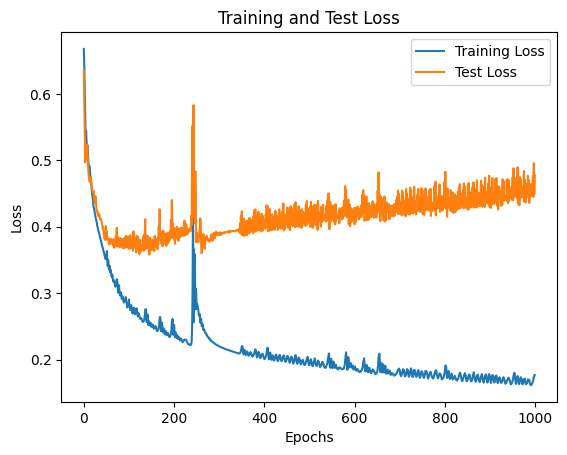

In [223]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

0.17697428166866302
Accuracy: 0.8381


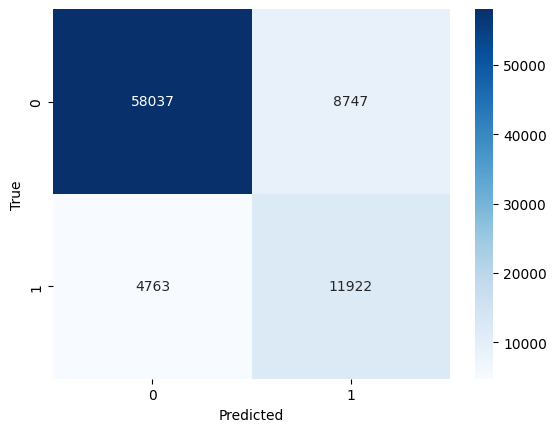

Confusion Matrix:
 [[58037  8747]
 [ 4763 11922]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.87      0.90     66784
         1.0       0.58      0.71      0.64     16685

    accuracy                           0.84     83469
   macro avg       0.75      0.79      0.77     83469
weighted avg       0.85      0.84      0.84     83469



In [224]:
model.eval()

with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs > 0.5).float()
    total = y_test_tensor.size(0)
    print(loss.item())
    correct = (predicted == y_test_tensor).sum().item()

print(f'Accuracy: {correct / total:.4f}')

y_true = y_test_tensor.numpy()
y_pred = predicted.numpy()

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=1))

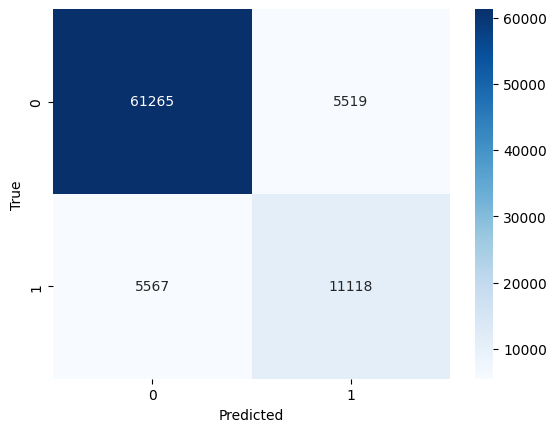

Accuracy: 0.8672
Confusion Matrix:
[[61265  5519]
 [ 5567 11118]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     66784
           1       0.67      0.67      0.67     16685

    accuracy                           0.87     83469
   macro avg       0.79      0.79      0.79     83469
weighted avg       0.87      0.87      0.87     83469



In [211]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 30,
    'eta': 0.5,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}

num_round = 1000
bst = xgb.train(params, dtrain, num_round)

y_pred = bst.predict(dtest)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))


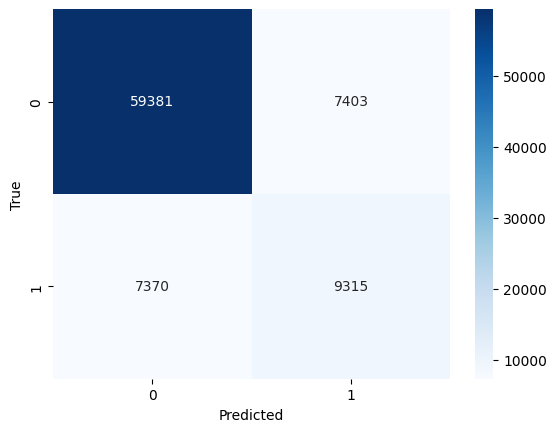

k-Nearest Neighbors (k-NN):
Accuracy: 0.8230121362421977
Confusion Matrix:
 [[59381  7403]
 [ 7370  9315]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     66784
           1       0.56      0.56      0.56     16685

    accuracy                           0.82     83469
   macro avg       0.72      0.72      0.72     83469
weighted avg       0.82      0.82      0.82     83469



In [216]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred_knn)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("k-Nearest Neighbors (k-NN):")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred_knn, zero_division=1))

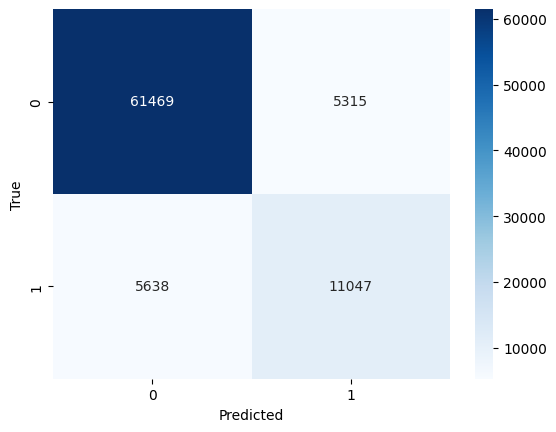

Accuracy: 0.8688
Confusion Matrix:
[[61469  5315]
 [ 5638 11047]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     66784
           1       0.68      0.66      0.67     16685

    accuracy                           0.87     83469
   macro avg       0.80      0.79      0.79     83469
weighted avg       0.87      0.87      0.87     83469



In [218]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train, y_train)
# y_pred_lr = lr.predict(X_test)

# print("Logistic Regression:")
# print("Accuracy:", accuracy_score(y_test, y_pred_lr))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
# print("Classification Report:\n", classification_report(y_test, y_pred_lr, zero_division=1))

In [ ]:
# svm_clf = SVC(kernel='rbf')
# svm_clf.fit(X_train, y_train)
# y_pred_svm = svm_clf.predict(X_test)
# acc_svm = accuracy_score(y_test, y_pred_svm)


# print("Support Vector Machine (SVM):")
# print("Accuracy:", acc_svm)
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
# print("Classification Report:\n", classification_report(y_test, y_pred_svm, zero_division=1))